In [22]:
import numpy as np
import pandas as pd
import tushare as ts
from talib.abstract import *

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math

from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
import os
os.chdir('/Users/xupech/Downloads')
sp5001 = pd.read_csv('./S&P_500.csv')

sp500 = sp5001.iloc[::-1].reset_index(drop=True)

sp500.index = sp500.Date
del sp500['Date']
sp500['log'] = np.log(sp500.Close)
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,log
Date,,,,,,,
12/30/1927,17.660000,17.660000,17.660000,17.660000,17.660000,0,2.871302
1/3/1928,17.760000,17.760000,17.760000,17.760000,17.760000,0,2.876949
1/4/1928,17.719999,17.719999,17.719999,17.719999,17.719999,0,2.874694
1/5/1928,17.549999,17.549999,17.549999,17.549999,17.549999,0,2.865054
1/6/1928,17.660000,17.660000,17.660000,17.660000,17.660000,0,2.871302


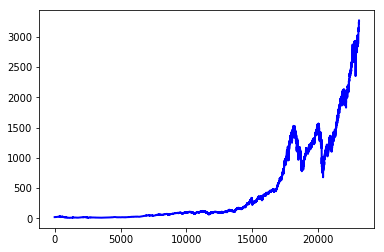

In [3]:
sp500['lag_close']=sp500.Close.shift(1)
sp500 = sp500[1:]
sp500['ret']=(sp500['Close']-sp500['lag_close'])
sp500['pcret']=(sp500['Close']-sp500['lag_close'])/sp500['lag_close']

ret = sp500.ret.values
close = sp500.Close.values
pcret = sp500.pcret.values

plt.plot(close,'b-', lw=2)

In [ ]:
#plt.plot(s4,'b-', lw=2)

In [4]:
pc_square = pcret**2
pc_square

sp500['pc_square'] = pc_square

In [5]:
sp500['squarelag'] = sp500['pc_square'].shift(1)
sp500=sp500.iloc[1:]

In [6]:
sp500['squarediff']=sp500['pc_square']-sp500['squarelag']
sp500['squaretmr']=sp500['pc_square'].shift(-1)
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,log,lag_close,ret,pcret,pc_square,squarelag,squarediff,squaretmr
Date,,,,,,,,,,,,,,
1/6/2020,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,8.085265,3234.850098,11.429931,0.003533,0.000012,0.000050,-0.000037,0.000008
1/7/2020,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,8.082458,3246.280029,-9.100097,-0.002803,0.000008,0.000012,-0.000005,0.000024
1/8/2020,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,8.087348,3237.179932,15.870117,0.004902,0.000024,0.000008,0.000016,0.000044
1/9/2020,3266.030029,3275.580078,3263.669922,3274.699951,3274.699951,3638390000,8.093982,3253.050049,21.649902,0.006655,0.000044,0.000024,0.000020,0.000008
1/10/2020,3281.810059,3282.989990,3260.860107,3265.350098,3265.350098,1631680402,8.091122,3274.699951,-9.349853,-0.002855,0.000008,0.000044,-0.000036,NaN


In [7]:
sp500['rollingvar']=sp500['pcret'].rolling(14).std()

In [8]:
sp500 = sp500.iloc[14:]
sp500['lagrolling'] = sp500['rollingvar'].shift(1)
sp500 = sp500.iloc[1:]
sp500['rvd']=sp500['rollingvar']-sp500['lagrolling']

In [9]:
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,log,lag_close,ret,pcret,pc_square,squarelag,squarediff,squaretmr,rollingvar,lagrolling,rvd
Date,,,,,,,,,,,,,,,,,
1/6/2020,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,8.085265,3234.850098,11.429931,0.003533,0.000012,0.000050,-0.000037,0.000008,0.004431,0.004420,0.000011
1/7/2020,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,8.082458,3246.280029,-9.100097,-0.002803,0.000008,0.000012,-0.000005,0.000024,0.004292,0.004431,-0.000139
1/8/2020,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,8.087348,3237.179932,15.870117,0.004902,0.000024,0.000008,0.000016,0.000044,0.004408,0.004292,0.000116
1/9/2020,3266.030029,3275.580078,3263.669922,3274.699951,3274.699951,3638390000,8.093982,3253.050049,21.649902,0.006655,0.000044,0.000024,0.000020,0.000008,0.004590,0.004408,0.000183
1/10/2020,3281.810059,3282.989990,3260.860107,3265.350098,3265.350098,1631680402,8.091122,3274.699951,-9.349853,-0.002855,0.000008,0.000044,-0.000036,NaN,0.004687,0.004590,0.000096


In [11]:

s0=pc_square
s1 = sp500['squarediff'].values
s2 = sp500['rollingvar'].values
s3 = sp500['rvd'].values

In [182]:
sp5002 = sp500.loc['12/29/2014':]
l1 = len(sp5002)
sp5002.tail()

s4=sp5002['pc_square']
s5=sp5002['squarediff']
s6=np.sqrt(sp5002['rollingvar'])
'''s3: squared return; s4: 1st difference of squared return.'''
s7=(sp5002['rvd']).values

sp500t1 = sp500.loc['9/4/2018':]
l2 = len(sp500t1)

'''To better scale s4. s4*10000.'''
s4=s4*10000
train4, test4 = s4[: l1-l2], s4[l1-l2:]
train5, test5 = s5[: l1-l2], s5[l1-l2:]

train4.tail()



Date
8/27/2018    0.588352
8/28/2018    0.000725
8/29/2018    0.325063
8/30/2018    0.196278
8/31/2018    0.000181
Name: pc_square, dtype: float64

In [183]:
sr = sp5002['pcret']
testsr = sr[l1-l2:]
sr=abs(sr)
len(sr)

1268

In [184]:
sr

Date
12/29/2014    0.000862
12/30/2014    0.004889
12/31/2014    0.010311
1/2/2015      0.000340
1/5/2015      0.018278
1/6/2015      0.008893
1/7/2015      0.011630
1/8/2015      0.017888
1/9/2015      0.008404
1/12/2015     0.008094
1/13/2015     0.002579
1/14/2015     0.005813
1/15/2015     0.009248
1/16/2015     0.013424
1/20/2015     0.001550
1/21/2015     0.004732
1/22/2015     0.015270
1/23/2015     0.005492
1/26/2015     0.002568
1/27/2015     0.013388
1/28/2015     0.013496
1/29/2015     0.009535
1/30/2015     0.012992
2/2/2015      0.012962
2/3/2015      0.014439
2/4/2015      0.004156
2/5/2015      0.010291
2/6/2015      0.003418
2/9/2015      0.004247
2/10/2015     0.010676
                ...   
11/27/2019    0.004174
11/29/2019    0.004011
12/2/2019     0.008631
12/3/2019     0.006638
12/4/2019     0.006324
12/5/2019     0.001500
12/6/2019     0.009136
12/9/2019     0.003163
12/10/2019    0.001097
12/11/2019    0.002908
12/12/2019    0.008575
12/13/2019    0.000073
12/16/

In [185]:
s6

Date
12/29/2014    0.106736
12/30/2014    0.107247
12/31/2014    0.104443
1/2/2015      0.104266
1/5/2015      0.105506
1/6/2015      0.106187
1/7/2015      0.106399
1/8/2015      0.105015
1/9/2015      0.096248
1/12/2015     0.096670
1/13/2015     0.096044
1/14/2015     0.096002
1/15/2015     0.096759
1/16/2015     0.101205
1/20/2015     0.101295
1/21/2015     0.101961
1/22/2015     0.104801
1/23/2015     0.105303
1/26/2015     0.098961
1/27/2015     0.101086
1/28/2015     0.102044
1/29/2015     0.097240
1/30/2015     0.098950
2/2/2015      0.101676
2/3/2015      0.104959
2/4/2015      0.104625
2/5/2015      0.103762
2/6/2015      0.101924
2/9/2015      0.102437
2/10/2015     0.103811
                ...   
11/27/2019    0.057201
11/29/2019    0.059805
12/2/2019     0.066122
12/3/2019     0.069055
12/4/2019     0.071108
12/5/2019     0.071158
12/6/2019     0.072339
12/9/2019     0.072997
12/10/2019    0.073055
12/11/2019    0.072417
12/12/2019    0.074734
12/13/2019    0.074791
12/16/

In [186]:
values_sr = sr.values.reshape(-1,1)
values_sr = values_sr.astype('float32')
scaler_sr = MinMaxScaler(feature_range=(0, 1))
scaled_sr = scaler_sr.fit_transform(values_sr)

scaled_sr

array([[0.01737667],
       [0.09857301],
       [0.20790644],
       ...,
       [0.09885221],
       [0.1341956 ],
       [0.05757134]], dtype=float32)

In [187]:
values_s6 = s6.values.reshape(-1,1)
values_s6 = values_s6.astype('float32')
scaler_s6 = MinMaxScaler(feature_range=(0, 1))
scaled_s6 = scaler_s6.fit_transform(values_s6)

scaled_s6

array([[0.58113784],
       [0.58564734],
       [0.5609025 ],
       ...,
       [0.22512889],
       [0.2371406 ],
       [0.24338382]], dtype=float32)

In [188]:
trainX, testX = scaled_s6[0:l1-l2,:], scaled_s6[l1-l2:len(scaled),:]
print(len(trainX), len(testX))

927 341


In [189]:
trainY, testY = scaled_sr[0:l1-l2,:], scaled_sr[l1-l2:len(scaled),:]
print(len(trainY), len(testY))

927 341


In [270]:
def create_dataset1(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [274]:
look_back = 14
wX, wY = create_dataset1(trainY, look_back)
xX, xY = create_dataset1(testY, look_back)

913
327


In [191]:
def create_dataset(Xset, Yset,look_back=1):
    dataX, dataY = [], []
    for i in range(len(Xset) - look_back):
        a = Xset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(Yset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [262]:
look_back = 28
train_x, train_y = create_dataset(trainX, trainY, look_back)
test_x, test_y = create_dataset(testX, testY, look_back)

899
313


In [263]:
train_x

array([[0.58113784, 0.58564734, 0.5609025 , ..., 0.56250715, 0.5548967 ,
        0.5386773 ],
       [0.58564734, 0.5609025 , 0.55934334, ..., 0.5548967 , 0.5386773 ,
        0.5432071 ],
       [0.5609025 , 0.55934334, 0.57028836, ..., 0.5386773 , 0.5432071 ,
        0.5553296 ],
       ...,
       [0.28375274, 0.2834081 , 0.2608751 , ..., 0.24855614, 0.2697022 ,
        0.26921743],
       [0.2834081 , 0.2608751 , 0.26368576, ..., 0.2697022 , 0.26921743,
        0.27496117],
       [0.2608751 , 0.26368576, 0.26013982, ..., 0.26921743, 0.27496117,
        0.25616646]], dtype=float32)

In [194]:
train_y

array([3.12529840e-02, 9.54076797e-02, 3.07896137e-01, 1.10730149e-01,
       5.17900214e-02, 2.69950628e-01, 2.72123218e-01, 1.92255795e-01,
       2.61967838e-01, 2.61372983e-01, 2.91155577e-01, 8.38018209e-02,
       2.07514212e-01, 6.89234585e-02, 8.56397226e-02, 2.15260252e-01,
       5.85432397e-04, 1.94470227e-01, 8.21623579e-02, 3.22132297e-02,
       6.33767620e-03, 2.14151517e-02, 1.23534404e-01, 6.11648383e-03,
       5.56273945e-02, 1.54399239e-02, 2.97623854e-02, 5.96104302e-02,
       1.23501852e-01, 9.15144160e-02, 8.84890482e-02, 2.41175611e-02,
       2.85801083e-01, 7.95346498e-02, 3.42005461e-01, 3.86677720e-02,
       2.54093349e-01, 1.22489467e-01, 2.72890687e-01, 6.69474304e-02,
       2.45160401e-01, 9.82498750e-02, 1.81731686e-01, 3.52006331e-02,
       1.23794280e-01, 2.93563366e-01, 4.79395203e-02, 4.77592833e-02,
       2.46737659e-01, 1.77356541e-01, 7.99570978e-02, 7.11716190e-02,
       1.33259043e-01, 4.15758863e-02, 5.40901497e-02, 8.98799077e-02,
      

In [264]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [275]:
wX = np.reshape(wX, (wX.shape[0], 1, wX.shape[1]))
xX = np.reshape(xX, (xX.shape[0], 1, xX.shape[1]))

In [276]:
model = Sequential()
model.add(LSTM(100, input_shape=(wX.shape[1], wX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(wX, wY, epochs= 100, batch_size=100, validation_data=(xX, xY), verbose=2, shuffle=False)

Train on 913 samples, validate on 327 samples
Epoch 1/100
 - 1s - loss: 0.0243 - val_loss: 0.0224
Epoch 2/100
 - 0s - loss: 0.0136 - val_loss: 0.0175
Epoch 3/100
 - 0s - loss: 0.0126 - val_loss: 0.0176
Epoch 4/100
 - 0s - loss: 0.0124 - val_loss: 0.0175
Epoch 5/100
 - 0s - loss: 0.0118 - val_loss: 0.0178
Epoch 6/100
 - 0s - loss: 0.0120 - val_loss: 0.0177
Epoch 7/100
 - 0s - loss: 0.0118 - val_loss: 0.0175
Epoch 8/100
 - 0s - loss: 0.0119 - val_loss: 0.0175
Epoch 9/100
 - 0s - loss: 0.0117 - val_loss: 0.0175
Epoch 10/100
 - 0s - loss: 0.0118 - val_loss: 0.0175
Epoch 11/100
 - 0s - loss: 0.0114 - val_loss: 0.0175
Epoch 12/100
 - 0s - loss: 0.0116 - val_loss: 0.0176
Epoch 13/100
 - 0s - loss: 0.0117 - val_loss: 0.0176
Epoch 14/100
 - 0s - loss: 0.0116 - val_loss: 0.0177
Epoch 15/100
 - 0s - loss: 0.0115 - val_loss: 0.0177
Epoch 16/100
 - 0s - loss: 0.0114 - val_loss: 0.0177
Epoch 17/100
 - 0s - loss: 0.0114 - val_loss: 0.0178
Epoch 18/100
 - 0s - loss: 0.0115 - val_loss: 0.0178
Epoch 19/

In [265]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_x, train_y, epochs= 100, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Train on 899 samples, validate on 313 samples
Epoch 1/100
 - 1s - loss: 0.0255 - val_loss: 0.0293
Epoch 2/100
 - 0s - loss: 0.0190 - val_loss: 0.0195
Epoch 3/100
 - 0s - loss: 0.0147 - val_loss: 0.0205
Epoch 4/100
 - 0s - loss: 0.0145 - val_loss: 0.0190
Epoch 5/100
 - 0s - loss: 0.0133 - val_loss: 0.0186
Epoch 6/100
 - 0s - loss: 0.0132 - val_loss: 0.0187
Epoch 7/100
 - 0s - loss: 0.0133 - val_loss: 0.0182
Epoch 8/100
 - 0s - loss: 0.0130 - val_loss: 0.0181
Epoch 9/100
 - 0s - loss: 0.0131 - val_loss: 0.0180
Epoch 10/100
 - 0s - loss: 0.0129 - val_loss: 0.0177
Epoch 11/100
 - 0s - loss: 0.0126 - val_loss: 0.0177
Epoch 12/100
 - 0s - loss: 0.0128 - val_loss: 0.0176
Epoch 13/100
 - 0s - loss: 0.0126 - val_loss: 0.0176
Epoch 14/100
 - 0s - loss: 0.0125 - val_loss: 0.0174
Epoch 15/100
 - 0s - loss: 0.0127 - val_loss: 0.0174
Epoch 16/100
 - 0s - loss: 0.0125 - val_loss: 0.0174
Epoch 17/100
 - 0s - loss: 0.0125 - val_loss: 0.0173
Epoch 18/100
 - 0s - loss: 0.0123 - val_loss: 0.0173
Epoch 19/

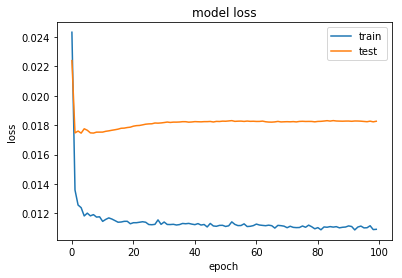

In [277]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [278]:
yhat = model.predict(test_x)
# invert scaling for forecast

yhat_inverse = scaler_sr.inverse_transform(yhat.reshape(-1, 1))
testy_inverse = scaler_sr.inverse_transform(test_y.reshape(-1, 1))

rmse = math.sqrt(mean_squared_error(testy_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)
# calculate RMSE

ValueError: Error when checking input: expected lstm_20_input to have shape (1, 14) but got array with shape (1, 28)

In [280]:
yhat = model.predict(xX)
# invert scaling for forecast

yhat_inverse = scaler_sr.inverse_transform(yhat.reshape(-1, 1))
testy_inverse = scaler_sr.inverse_transform(xY.reshape(-1, 1))

rmse = math.sqrt(mean_squared_error(testy_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)
# calculate RMSE

Test RMSE: 0.007


In [217]:
yhat

array([[0.07359097],
       [0.07266416],
       [0.06848758],
       [0.06263321],
       [0.06133366],
       [0.05753321],
       [0.06161061],
       [0.06412607],
       [0.05640584],
       [0.0742593 ],
       [0.07442383],
       [0.06601603],
       [0.06725986],
       [0.16878296],
       [0.19199498],
       [0.22317265],
       [0.21435675],
       [0.19366932],
       [0.15814096],
       [0.1434337 ],
       [0.16129144],
       [0.14840011],
       [0.15491961],
       [0.17707564],
       [0.18617293],
       [0.19803478],
       [0.23020557],
       [0.20120557],
       [0.17336811],
       [0.16037084],
       [0.1772704 ],
       [0.16921751],
       [0.1816248 ],
       [0.19652149],
       [0.19187547],
       [0.20062451],
       [0.22550038],
       [0.18049577],
       [0.15988837],
       [0.1375992 ],
       [0.13116878],
       [0.15715654],
       [0.1876662 ],
       [0.19665076],
       [0.18084635],
       [0.19088423],
       [0.18348007],
       [0.187

In [215]:
testy_inverse

array([[3.5156878e-03],
       [1.3050960e-03],
       [3.2892781e-03],
       [2.7632869e-03],
       [6.8702820e-06],
       [3.6411053e-03],
       [3.9669010e-04],
       [7.1151968e-04],
       [8.1694825e-03],
       [5.5279788e-03],
       [3.9511637e-04],
       [1.4179037e-03],
       [3.2864228e-02],
       [2.0573007e-02],
       [1.4206197e-02],
       [5.9049791e-03],
       [2.1495601e-02],
       [2.5266237e-04],
       [1.4391922e-02],
       [3.6116989e-04],
       [4.2995275e-03],
       [5.5118301e-03],
       [3.0864434e-02],
       [1.8625040e-02],
       [1.7327264e-02],
       [6.5595992e-03],
       [1.5666781e-02],
       [1.0851332e-02],
       [1.0557843e-02],
       [6.3166856e-03],
       [5.6003174e-03],
       [6.2592952e-03],
       [2.1208856e-02],
       [2.5089167e-03],
       [9.1990139e-03],
       [1.9701490e-02],
       [1.4819197e-03],
       [7.5674108e-03],
       [1.0593753e-02],
       [2.2233056e-03],
       [1.6643109e-02],
       [1.815124

In [216]:
test_y

array([7.08897412e-02, 2.63157375e-02, 6.63244575e-02, 5.57184592e-02,
       1.38531221e-04, 7.34186396e-02, 7.99879339e-03, 1.43469647e-02,
       1.64728090e-01, 1.11465245e-01, 7.96706043e-03, 2.85903737e-02,
       6.62668824e-01, 4.14830685e-01, 2.86451399e-01, 1.19067013e-01,
       4.33433712e-01, 5.09464182e-03, 2.90196329e-01, 7.28256954e-03,
       8.66949558e-02, 1.11139625e-01, 6.22345328e-01, 3.75552207e-01,
       3.49384069e-01, 1.32266670e-01, 3.15902352e-01, 2.18804449e-01,
       2.12886602e-01, 1.27368599e-01, 1.12923868e-01, 1.26211390e-01,
       4.27651852e-01, 5.05893789e-02, 1.85487390e-01, 3.97257566e-01,
       2.98811812e-02, 1.52588010e-01, 2.13610679e-01, 4.48303632e-02,
       3.35588872e-01, 3.65998596e-01, 6.13644086e-02, 1.32170752e-01,
       3.13192070e-01, 6.57682195e-02, 4.63243484e-01, 4.40198258e-02,
       1.64753586e-01, 2.20621094e-01, 6.52600467e-01, 3.06939594e-02,
       4.70222980e-01, 3.55317816e-02, 7.18530966e-03, 1.09277964e-01,
      

In [233]:
new = np.zeros(len(yhat_inverse))
new = new+0.005

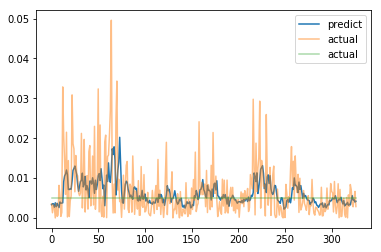

In [281]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testy_inverse, label='actual', alpha=0.5)
plt.plot(new, label='actual', alpha=0.4)
plt.legend()
plt.show()

In [282]:
k1 = yhat_inverse[yhat_inverse>0.005]
len(k1)

176

In [283]:
k2 = testy_inverse[testy_inverse>0.005]
len(k2>0.1)

154

In [284]:
k1 = np.array(yhat_inverse)
k1

array([[0.00331376],
       [0.00356992],
       [0.00355896],
       [0.00269122],
       [0.00380316],
       [0.0028064 ],
       [0.00366727],
       [0.00310653],
       [0.00260984],
       [0.00400366],
       [0.00368526],
       [0.00374126],
       [0.00379217],
       [0.00909829],
       [0.01053674],
       [0.01100382],
       [0.01201749],
       [0.01088931],
       [0.00715586],
       [0.00712338],
       [0.00733471],
       [0.00718367],
       [0.00931432],
       [0.01190913],
       [0.01240142],
       [0.01302116],
       [0.01193596],
       [0.01084663],
       [0.00832265],
       [0.00668713],
       [0.00788185],
       [0.00918586],
       [0.00936911],
       [0.0112399 ],
       [0.00780047],
       [0.00844446],
       [0.010435  ],
       [0.00701303],
       [0.00810833],
       [0.00711117],
       [0.00509578],
       [0.00924325],
       [0.00923297],
       [0.00848333],
       [0.01007828],
       [0.00878578],
       [0.00617932],
       [0.009

In [287]:
All = pd.DataFrame(np.hstack((testy_inverse[:], yhat_inverse[:])))
All.columns = ['a', 'b']
All['Real'] = All['a']>0.005
All['Predict'] = All['b']>0.005

All['True'] = All['Real']==All['Predict']

In [288]:
n1=len(All[All['True']==True])
n2=len(All)
n1/n2

0.6085626911314985

In [115]:
test6 = s6[l1-l2: ]
len(test6)

1016

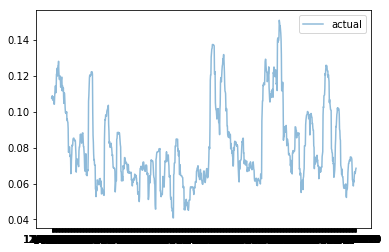

In [116]:
plt.plot(test6, label='actual', alpha=0.5)
plt.legend()
plt.show()

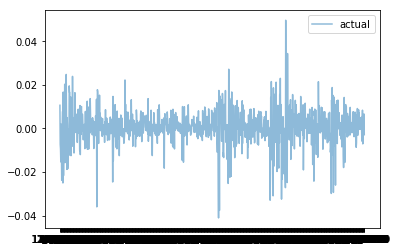

In [117]:
plt.plot(testsr, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [119]:
from scipy.stats import pearsonr
corr, _ = pearsonr(abs(testsr), sr)
print('Pearsons correlation: %.3f' % corr)

ValueError: x and y must have the same length.

In [115]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()

In [142]:
garch = arch_model(train4, vol='GARCH', p=1, o=1, q=1)
res = garch.fit(update_freq=5,disp='off') 
#resid = res.resid

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:              pc_square   R-squared:                      -0.039
Mean Model:             Constant Mean   Adj. R-squared:                 -0.039
Vol Model:                  GJR-GARCH   Log-Likelihood:               -10780.3
Distribution:                  Normal   AIC:                           21570.6
Method:            Maximum Likelihood   BIC:                           21603.5
                                        No. Observations:                 5287
Date:                Wed, Feb 26 2020   Df Residuals:                     5282
Time:                        21:40:08   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5473  5.239e-02     10.445  1.544e-25 [  0.445,  0.650]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1118  8.630e-02      1.296      0.195 [-5.731e-02,  0.281]
alpha[1]       0.3442      0.183      1.881  6.001e-02 [-1.451e-02,  0.703]
gamma[1]      -0.3442      0.521     -0.661      0.509    [ -1.365,  0.677]
beta[1]        0.8073  4.863e-02     16.601  6.858e-62    [  0.712,  0.903]
===========================================================================

Covariance estimator: robust
"""

In [147]:
tarch = arch_model(train4, p=14, o=2, q=1, power=1.0)
res1 = tarch.fit()
res1.summary()

Iteration:      1,   Func. Count:     21,   Neg. LLF: 12660.982903867567
Iteration:      2,   Func. Count:     48,   Neg. LLF: 12241.633644185888
Iteration:      3,   Func. Count:     72,   Neg. LLF: 11595.877543465354
Iteration:      4,   Func. Count:     94,   Neg. LLF: 11119.591533256518
Iteration:      5,   Func. Count:    119,   Neg. LLF: 11113.875650252174
Iteration:      6,   Func. Count:    141,   Neg. LLF: 11071.448032974444
Iteration:      7,   Func. Count:    163,   Neg. LLF: 11004.34533799821
Iteration:      8,   Func. Count:    185,   Neg. LLF: 10979.779249320374
Iteration:      9,   Func. Count:    208,   Neg. LLF: 10893.806349577757
Iteration:     10,   Func. Count:    230,   Neg. LLF: 10876.212328140402
Iteration:     11,   Func. Count:    252,   Neg. LLF: 10863.891499808418
Iteration:     12,   Func. Count:    274,   Neg. LLF: 10821.643596129972
Iteration:     13,   Func. Count:    297,   Neg. LLF: 10816.666401407409
Iteration:     14,   Func. Count:    319,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Dep. Variable:              pc_square   R-squared:                      -0.039
Mean Model:             Constant Mean   Adj. R-squared:                 -0.039
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -10636.7
Distribution:                  Normal   AIC:                           21311.4
Method:            Maximum Likelihood   BIC:                           21436.3
                                        No. Observations:                 5287
Date:                Wed, Feb 26 2020   Df Residuals:                     5268
Time:                        21:48:44   Df Model:                           19
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5437  1.258e-02     43.222      0.000 [  0.519,  0.568]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1519  6.570e-02      2.312  2.077e-02    [2.314e-02,  0.281]
alpha[1]       0.1567  6.223e-02      2.518  1.181e-02    [3.471e-02,  0.279]
alpha[2]       0.2209      0.108      2.040  4.139e-02    [8.624e-03,  0.433]
alpha[3]       0.0000      0.114      0.000      1.000      [ -0.224,  0.224]
alpha[4]       0.0000      0.114      0.000      1.000      [ -0.223,  0.223]
alpha[5]       0.0000  8.953e-02      0.000      1.000      [ -0.175,  0.175]
alpha[6]   1.4045e-10  7.250e-02  1.937e-09      1.000      [ -0.142,  0.142]
alpha[7]       0.0343  8.090e-02      0.424      0.672      [ -0.124,  0.193]
alpha[8]       0.0000  7.726e-02      0.000      1.000      [ -0.151,  0.151]
alpha[9]       0.0000  5.818e-02      0.000      1.000      [ -0.114,  0.114]
alpha[10]  1.5578e-09  5.074e-02  3.070e-08      1.000 [-9.944e-02,9.944e-02]
alpha[11]      0.0000  5.207e-02      0.000      1.000      [ -0.102,  0.102]
alpha[12]      0.0000  5.478e-02      0.000      1.000      [ -0.107,  0.107]
alpha[13]  1.7846e-09  4.690e-02  3.805e-08      1.000 [-9.192e-02,9.192e-02]
alpha[14]      0.0116  3.275e-02      0.356      0.722 [-5.255e-02,7.584e-02]
gamma[1]      -0.1567      0.259     -0.605      0.545      [ -0.664,  0.351]
gamma[2]      -0.2209      0.240     -0.920      0.357      [ -0.691,  0.249]
beta[1]        0.7653  5.468e-02     13.997  1.631e-44      [  0.658,  0.872]
=============================================================================

Covariance estimator: robust
"""

In [150]:
index = train4.index
end_loc = np.where(index >= '2010-1-1')[0].min()

end_loc

42

In [91]:
sp5003 = sp5002[['pc_square', 'squarediff', 'squaretmr']].copy()


'''Dataframe for s3, s4: squared return, and 1st difference of squared return.'''

sp5003.tail()

,pc_square,squarediff,squaretmr
Date,,,
1/6/2020,0.000012,-0.000037,0.000008
1/7/2020,0.000008,-0.000005,0.000024
1/8/2020,0.000024,0.000016,0.000044
1/9/2020,0.000044,0.000020,0.000008
1/10/2020,0.000008,-0.000036,NaN


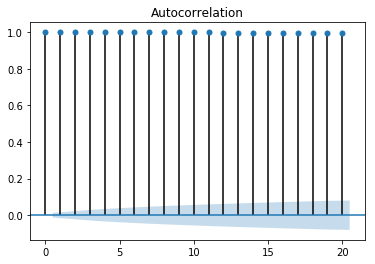

In [12]:
sm.graphics.tsa.plot_acf(sp500['log'], lags = 20)
plt.show()

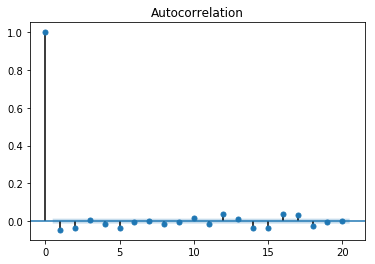

In [8]:
sm.graphics.tsa.plot_acf(sp500['ret'], lags = 20)
plt.show()

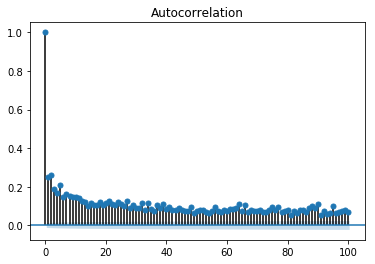

In [10]:
sm.graphics.tsa.plot_acf(s0, lags=100)
>>> plt.show()

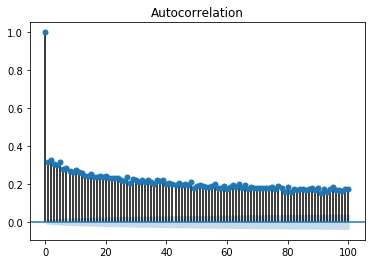

In [45]:
sm.graphics.tsa.plot_acf(s1, lags=100)
>>> plt.show()

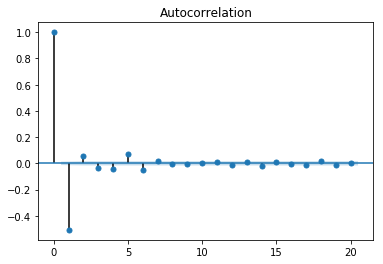

In [16]:
sm.graphics.tsa.plot_acf(s2, lags = 20)
plt.show()

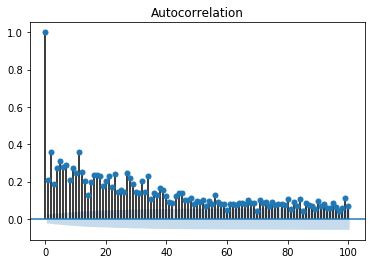

In [72]:
sm.graphics.tsa.plot_acf(s3, lags=100)
>>> plt.show()

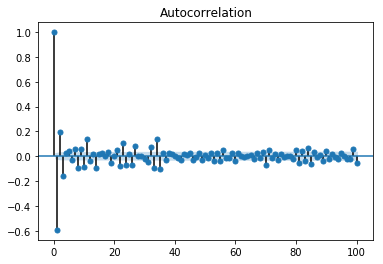

In [73]:
sm.graphics.tsa.plot_acf(s4, lags=100)
>>> plt.show()

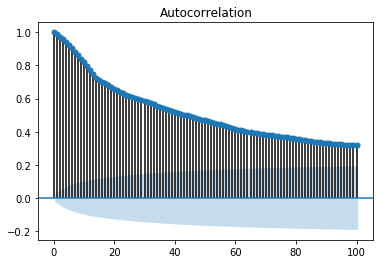

In [104]:
sm.graphics.tsa.plot_acf(s5, lags=100)
>>> plt.show()

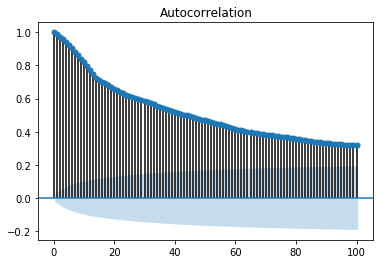

In [109]:
sm.graphics.tsa.plot_acf(s6, lags=100)
>>> plt.show()

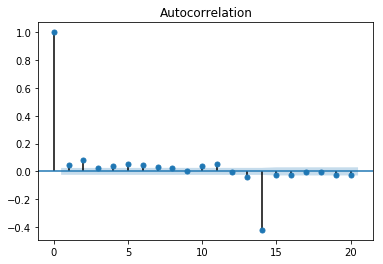

In [111]:
sm.graphics.tsa.plot_acf(s7, lags=20)
plt.show()

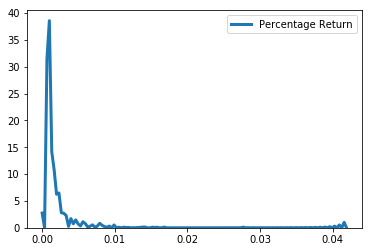

In [14]:
sns.distplot(pc_square, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'Percentage Return')

In [80]:
result = adfuller(s3)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
'''Augmented Fuller Test: stationary time series data: squared return.'''

ADF Statistic: -6.781126
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [79]:
result = adfuller(s4)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
'''Augmented Fuller Test: stationary time series data: first difference of squared return.'''

ADF Statistic: -18.011654
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [60]:
s1 = s1.reshape(len(s1), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(s1)
scaled_X = scaler.transform(s1)

array([[-0.99846911],
       [-0.9997578 ],
       [-0.99560565],
       ...,
       [-0.9988525 ],
       [-0.99788527],
       [-0.99961078]])

In [96]:
#X = train3[:, 0:-1]
y = train3[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

IndexError: too many indices for array

In [111]:
print('Change greater than 0.5%: ' +str(len(sp500[sp500['>0.5%'] != 1000])))
print('Change greater than 0.6%: ' +str(len(sp500[sp500['>0.6%']!= 1000])))
print('Change greater than 0.7%: ' +str(len(sp500[sp500['>0.7%']!= 1000])))
print('Change greater than 0.8%: ' +str(len(sp500[sp500['>0.8%']!= 1000])))
print('Change greater than 0.9%: ' +str(len(sp500[sp500['>0.9%']!= 1000])))
print('Change greater than 1.0%: ' +str(len(sp500[sp500['>1.0%']!= 1000])))

Change greater than 0.5%: 11505
Change greater than 0.6%: 9911
Change greater than 0.7%: 8548
Change greater than 0.8%: 7400
Change greater than 0.9%: 6380
Change greater than 1.0%: 5544


In [112]:
threshold5 = sp500[sp500['>0.5%']!= 1000]
threshold5 = threshold5['>0.5%'].values
threshold5

array([ 0.00566251, -0.00959368,  0.00626786, ...,  0.0083788 ,
       -0.00705987,  0.00665526])

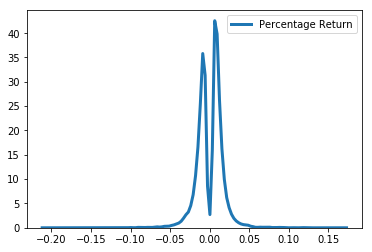

In [113]:
sns.distplot(threshold5, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'Percentage Return')

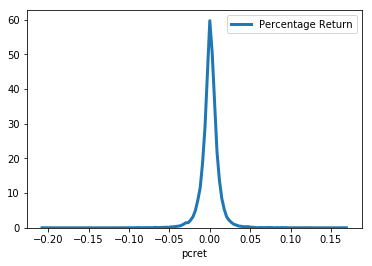

In [17]:
sns.distplot(sp500['pcret'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'Percentage Return')

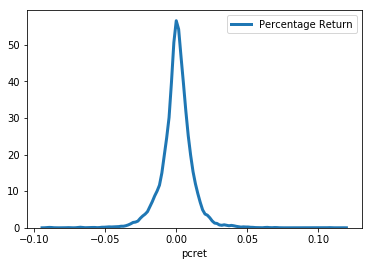

In [18]:
sns.distplot(sp5002['pcret'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'Percentage Return')

In [53]:
sp5002log = sp5002[['log']].copy()
sp5002log.to_csv('sp500log.csv')

In [ ]:
#decompose = seasonal_decompose(sp5002close, model='multiplicative', period = 12)
#fig = plt.figure()  
#fig = decompose.plot()  
#fig.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(sp5002log.log); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(sp5002log.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(sp5002log.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(sp5002log.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(sp5002log.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [28]:
from pylab import rcParams

log2
moving_avg = sp5002close['log'].rolling(12).mean()
moving_std = sp5002close['log'].rolling(12).std()

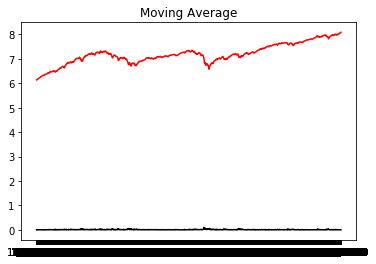

In [29]:
plt.title('Moving Average')
plt.plot(moving_std, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.show()

In [30]:
train_data, test_data = sp5002close[:int(len(sp5002close)*0.9)], sp5002close[int(len(sp5002close)*0.9):]

In [31]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-34234.592, BIC=-34221.305, Time=0.528 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-34256.056, BIC=-34236.127, Time=0.255 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-34258.421, BIC=-34238.491, Time=0.745 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-34233.113, BIC=-34226.470, Time=0.189 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-34267.225, BIC=-34240.653, Time=1.187 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-34265.910, BIC=-34232.695, Time=0.549 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-34266.122, BIC=-34232.907, Time=1.392 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-34268.168, BIC=-34241.596, Time=1.289 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=-34266.100, BIC=-34232.884, Time=1.507 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (con

In [185]:
smodel = auto_arima(sp500['squarediff'], start_p=1, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=-273844.273, BIC=-273804.035, Time=64.831 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=-250005.681, BIC=-249989.586, Time=6.687 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=-263989.618, BIC=-263957.427, Time=76.423 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=-274274.785, BIC=-274242.594, Time=97.233 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=-250007.677, BIC=-249999.629, Time=2.321 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=-261125.899, BIC=-261101.756, Time=15.020 seconds
Fit ARIMA: (0, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=-271555.092, BIC=-271514.854, Time=57.086 seconds


KeyboardInterrupt: 

In [186]:
mod1 = SARIMAX(sp500['squarediff'],
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod1.fit()
print(results1.summary().tables[1])

/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.167e-06   7.44e-10   1568.203      0.000    1.17e-06    1.17e-06


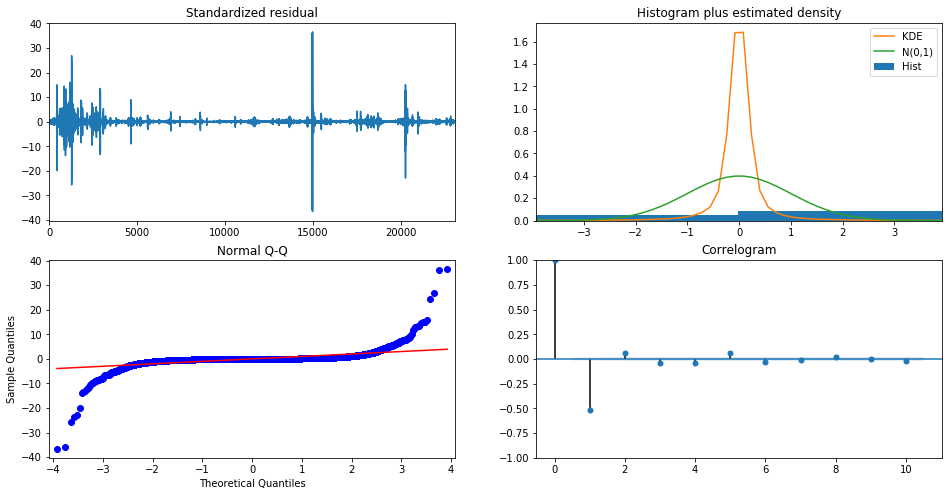

In [187]:
results1.plot_diagnostics(figsize=(16, 8))
plt.show()

/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7618      0.005    139.744      0.000       0.751       0.772
ar.S.L12      -0.6744      0.272     -2.476      0.013      -1.208      -0.141
ar.S.L24      -0.0980      0.037     -2.627      0.009      -0.171      -0.025
ma.S.L12      -0.4655      0.273     -1.706      0.088      -1.000       0.069
ma.S.L24      -0.5191      0.271     -1.918      0.055      -1.050       0.011
sigma2         0.0005   4.72e-06    112.019      0.000       0.001       0.001


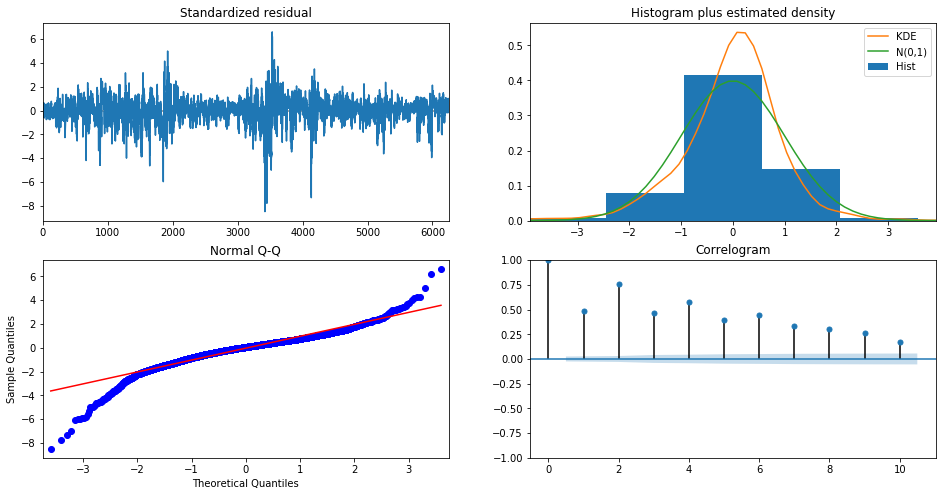

In [74]:
mod2 = SARIMAX(sp5002log['log'],
                                order=(0, 0, 1),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary().tables[1])

results2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [66]:
mod = SARIMAX(sp5002log['log'],
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xupech/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0194      0.008     -2.375      0.018      -0.035      -0.003
sigma2         0.0012   1.13e-05    107.899      0.000       0.001       0.001


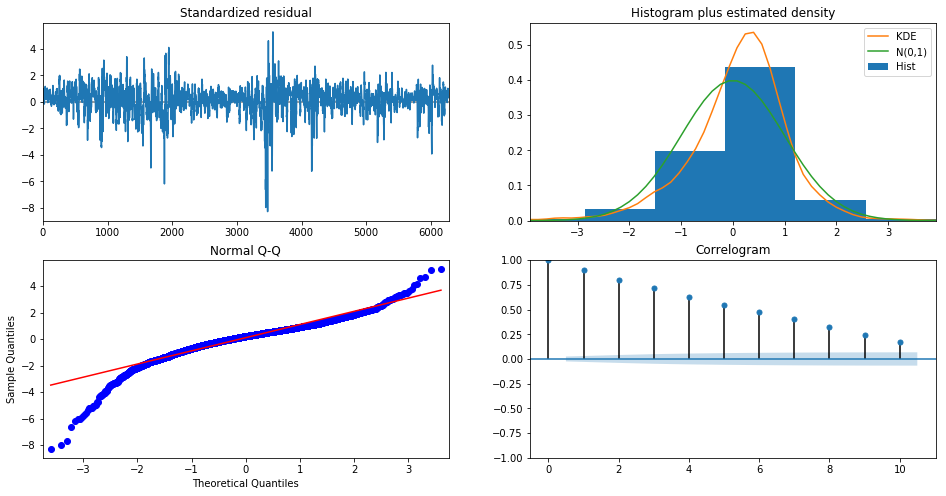

In [67]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

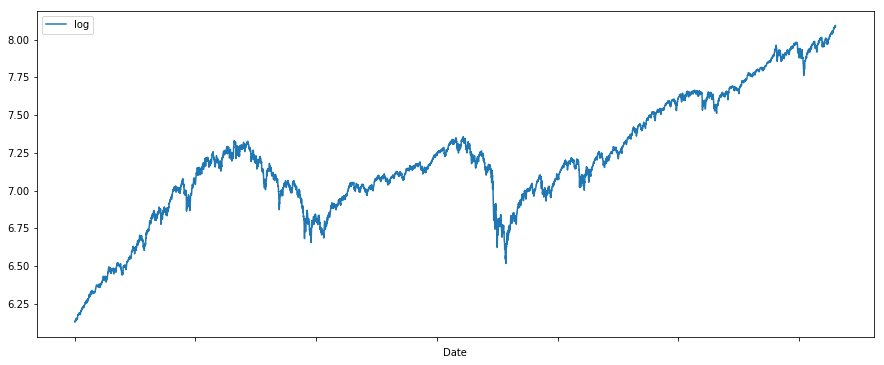

In [30]:
sp5002log.plot(figsize=(15, 6))
plt.show()

In [115]:
sp5003 = sp500.loc['1/5/2017':]
pred = results.get_prediction(start='1/5/2017', dynamic=False)
sp5003['pred'] = pred.predicted_mean

sp5003['lag_log']=sp5003.log.shift(1)

/Users/xupech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xupech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [116]:
sp5003 = sp5003[1:]

In [117]:
sp5003.head()

,Open,High,Low,Close,Adj Close,Volume,log,lag_close,ret,pcret,>0.5%,>0.6%,>0.7%,>0.8%,>0.9%,>1.0%,pred,lag_log
Date,,,,,,,,,,,,,,,,,,
1/6/2017,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3339890000,7.730605,2269.000000,7.979980,0.003517,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.723613,7.727094
1/9/2017,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3217610000,7.727050,2276.979980,-8.080078,-0.003549,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.727184,7.730605
1/10/2017,2269.719971,2279.270020,2265.270020,2268.899902,2268.899902,3638790000,7.727050,2268.899902,0.000000,0.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.724881,7.727050
1/11/2017,2268.600098,2275.320068,2260.830078,2275.320068,2275.320068,3620410000,7.729876,2268.899902,6.420166,0.002830,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.723118,7.727050
1/12/2017,2271.139893,2271.780029,2254.250000,2270.439941,2270.439941,3462130000,7.727729,2275.320068,-4.880127,-0.002145,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.724592,7.729876


In [118]:
sp5003['prediction'] = sp5003.pred-sp5003.lag_log

print('Total data points from 2017/1/5: '+ str(len(sp5003[sp5003['pcret'] > 0])))
len(sp5003[sp5003['pcret'] > 0])/len(sp5003)

Total data points from 2017/1/5: 427


0.5633245382585752

In [150]:
sp5003['0.9%direction'] = sp5003['>0.9%'].map(lambda x: bool(x>0) if x != 1000 else 1000)
sp5003['preddirection'] = sp5003['prediction'] > 0
#np.sum(sp5003['preddirection'])
sp5003

,Open,High,Low,Close,Adj Close,Volume,log,lag_close,ret,pcret,...,pred,lag_log,prediction,0.5%direction,preddirection,0.5agree,0.7%direction,0.agree,0.7agree,0.9%direction
Date,,,,,,,,,,,,,,,,,,,,,
1/6/2017,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3339890000,7.730605,2269.000000,7.979980,0.003517,...,7.723613,7.727094,-0.003482,1000,False,False,1000,False,False,1000
1/9/2017,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3217610000,7.727050,2276.979980,-8.080078,-0.003549,...,7.727184,7.730605,-0.003422,1000,False,False,1000,False,False,1000
1/10/2017,2269.719971,2279.270020,2265.270020,2268.899902,2268.899902,3638790000,7.727050,2268.899902,0.000000,0.000000,...,7.724881,7.727050,-0.002170,1000,False,False,1000,False,False,1000
1/11/2017,2268.600098,2275.320068,2260.830078,2275.320068,2275.320068,3620410000,7.729876,2268.899902,6.420166,0.002830,...,7.723118,7.727050,-0.003932,1000,False,False,1000,False,False,1000
1/12/2017,2271.139893,2271.780029,2254.250000,2270.439941,2270.439941,3462130000,7.727729,2275.320068,-4.880127,-0.002145,...,7.724592,7.729876,-0.005284,1000,False,False,1000,False,False,1000
1/13/2017,2272.739990,2278.679932,2271.510010,2274.639893,2274.639893,3081270000,7.729577,2270.439941,4.199952,0.001850,...,7.726838,7.727729,-0.000890,1000,False,False,1000,False,False,1000
1/17/2017,2269.139893,2272.080078,2262.810059,2267.889893,2267.889893,3584990000,7.726605,2274.639893,-6.750000,-0.002968,...,7.718723,7.729577,-0.010854,1000,False,False,1000,False,False,1000
1/18/2017,2269.139893,2272.010010,2263.350098,2271.889893,2271.889893,3315250000,7.728367,2267.889893,4.000000,0.001764,...,7.718414,7.726605,-0.008191,1000,False,False,1000,False,False,1000
1/19/2017,2271.899902,2274.330078,2258.409912,2263.689941,2263.689941,3165970000,7.724751,2271.889893,-8.199952,-0.003609,...,7.713981,7.728367,-0.014386,1000,False,False,1000,False,False,1000


In [153]:
sp5003['0.9agree'] = sp5003['0.9%direction'] == sp5003['preddirection']
sp5003_1 = sp5003[sp5003['0.9%direction'] != 1000]
np.sum(sp5003_1['0.9agree'])/len(sp5003_1)
sp5003_1

,Open,High,Low,Close,Adj Close,Volume,log,lag_close,ret,pcret,...,lag_log,prediction,0.5%direction,preddirection,0.5agree,0.7%direction,0.agree,0.7agree,0.9%direction,0.9agree
Date,,,,,,,,,,,,,,,,,,,,,
3/1/2017,2380.129883,2400.979980,2380.129883,2395.959961,2395.959961,4345180000,7.781539,2363.639893,32.320068,0.013674,...,7.767958,-0.020470,True,False,False,True,False,False,True,False
3/21/2017,2379.320068,2381.929932,2341.899902,2344.020020,2344.020020,4265590000,7.759623,2373.469971,-29.449951,-0.012408,...,7.772108,0.003677,False,True,False,False,False,False,False,False
4/24/2017,2370.330078,2376.979980,2369.189941,2374.149902,2374.149902,3690650000,7.772395,2348.689941,25.459961,0.010840,...,7.761613,0.001981,True,True,True,True,True,True,True,True
5/17/2017,2382.949951,2384.870117,2356.209961,2357.030029,2357.030029,4163000000,7.765158,2400.669922,-43.639893,-0.018178,...,7.783503,-0.005509,False,False,True,False,True,True,False,True
7/6/2017,2423.439941,2424.280029,2407.699951,2409.750000,2409.750000,3364520000,7.787278,2432.540039,-22.790039,-0.009369,...,7.796691,0.008373,False,True,False,False,False,False,False,False
8/10/2017,2465.379883,2465.379883,2437.750000,2438.209961,2438.209961,3621070000,7.799019,2474.020020,-35.810059,-0.014474,...,7.813600,0.000848,False,True,False,False,False,False,False,False
8/14/2017,2454.959961,2468.219971,2454.959961,2465.840088,2465.840088,2822550000,7.810288,2441.320068,24.520020,0.010044,...,7.800294,0.013478,True,True,True,True,True,True,True,True
8/17/2017,2462.949951,2465.020020,2430.010010,2430.010010,2430.010010,3142620000,7.795651,2468.110107,-38.100097,-0.015437,...,7.811208,0.003193,False,True,False,False,False,False,False,False
8/22/2017,2433.750000,2454.770020,2433.669922,2452.510010,2452.510010,2777490000,7.804867,2428.370117,24.139893,0.009941,...,7.794976,0.019728,True,True,True,True,True,True,True,True


In [93]:
(np.sum(sp5003.pred_sign == sp5003.real_sign))/len(sp5003)

0.9064558629776021

In [94]:
(np.sum(sp5003.real_sign == True))/len(sp5003)

0.6903820816864296

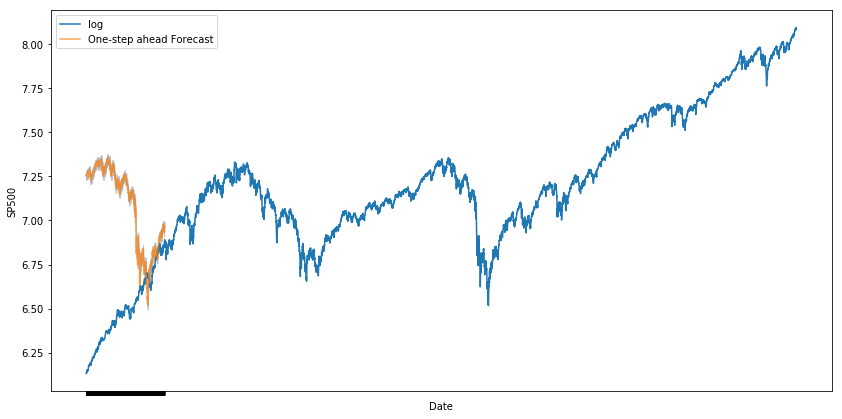

In [95]:
pred = results.get_prediction(start='1/5/2007', end = '10/9/2009', dynamic=False)
pred_ci = pred.conf_int()
ax = sp5002log['1/5/1995':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('SP500')
plt.legend()
plt.show()

In [103]:
sp5004 = sp500.loc['1/5/2007':'10/9/2009']
pred = results.get_prediction(start='1/5/2007', dynamic=False)
sp5004['pred'] = pred.predicted_mean

sp5004['lag_log']=sp5004.log.shift(10)

/Users/xupech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xupech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [104]:

sp5004['pred_sign'] = sp5004.pred-sp5004.lag_log > 0
sp5004['real_sign']=sp5004.log-sp5004.lag_log >0

/Users/xupech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/xupech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
sp5004

,Open,High,Low,Close,Adj Close,Volume,log,lag_close,ret,pcret,pred,lag_log,pred_sign,real_sign
Date,,,,,,,,,,,,,,
1/5/2007,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000,7.251139,1418.339966,-8.630005,-0.006085,7.258548,NaN,False,False
1/8/2007,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000,7.253357,1409.709961,3.130005,0.002220,7.251645,NaN,False,False
1/9/2007,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000,7.252840,1412.839966,-0.729981,-0.000517,7.253740,NaN,False,False
1/10/2007,1408.699951,1415.989990,1405.319946,1414.849976,1414.849976,2764660000,7.254779,1412.109985,2.739991,0.001940,7.252065,NaN,False,False
1/11/2007,1414.839966,1427.119995,1414.839966,1423.819946,1423.819946,2857870000,7.261099,1414.849976,8.969970,0.006340,7.254491,NaN,False,False
1/12/2007,1423.819946,1431.229980,1422.579956,1430.729980,1430.729980,2686480000,7.265940,1423.819946,6.910034,0.004853,7.260355,NaN,False,False
1/16/2007,1430.729980,1433.930054,1428.619995,1431.900024,1431.900024,2599530000,7.266758,1430.729980,1.170044,0.000818,7.266397,NaN,False,False
1/17/2007,1431.770020,1435.270020,1428.569946,1430.619995,1430.619995,2690270000,7.265863,1431.900024,-1.280029,-0.000894,7.266295,NaN,False,False
1/18/2007,1430.589966,1432.959961,1424.209961,1426.369995,1426.369995,2822430000,7.262888,1430.619995,-4.250000,-0.002971,7.266086,NaN,False,False


In [101]:
(np.sum(sp5004.pred_sign == sp5004.real_sign))/len(sp5004)

0.5208034433285509

In [25]:
model = ARIMA(train_data, order=(0, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

NameError: name 'train_data' is not defined